In [ ]:
!pip uninstall pyarrow
!pip install pyarrow

In [ ]:
!pip install --upgrade ipykernel jupyter notebook


In [ ]:
!pip uninstall numpy

!pip install numpy==1.26.4


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data preparation

## Setting up paths and load data

In [6]:
# Set up data paths
base_dir = '../data/raw/archive/'
csv_path = 'Folds.csv'

# Load data
df = pd.read_csv(base_dir + csv_path)

# Process file paths - rename the filename column to path
df = df.rename(columns={'filename': 'path'})

# Check what the path column contains
print("Sample paths from CSV:")
print(df['path'].head(3))
print("\nFirst path structure:", df['path'].iloc[0] if len(df) > 0 else "No data")

first_path = df['path'].iloc[0] if len(df) > 0 else ""


df['path_clean'] = df['path'].str.replace(r'^BreaKHis_v1/', '', regex=True)
df['path_clean'] = df['path_clean'].str.replace(r'^/BreaKHis_v1/', '/', regex=True)

# Determining img_dir based on what remains
path_clean_first = df['path_clean'].iloc[0] if len(df) > 0 else ""

if path_clean_first.startswith('histology_slides'):
    # Path starts with histology_slides, need to add BreaKHis_v1
    img_dir = os.path.join(base_dir, 'BreaKHis_v1')
elif path_clean_first.startswith(('benign', 'malignant')):
    # Path starts with class name, need full path
    img_dir = os.path.join(base_dir, 'BreaKHis_v1', 'histology_slides', 'breast')
else:
    # Default: assume path needs BreaKHis_v1
    img_dir = os.path.join(base_dir, 'BreaKHis_v1')

# Normalize the path separator for Windows compatibility
img_dir = img_dir.replace('\\', '/')

# Construct full file paths
df['filepath'] = img_dir + '/' + df['path_clean']

# Clean up any double slashes
df['filepath'] = df['filepath'].str.replace('//', '/', regex=False)
df['filepath'] = df['filepath'].str.replace('//', '/', regex=False)  # Do twice to handle triple slashes

# Verify the path construction
print(f"\nImage directory: {img_dir}")
print(f"Sample cleaned path: {df['path_clean'].iloc[0] if len(df) > 0 else 'No data'}")
print(f"Sample filepath: {df['filepath'].iloc[0] if len(df) > 0 else 'No data'}")

# Check if files exist (sample check on multiple files)
if len(df) > 0:
    sample_paths = df['filepath'].head(5).tolist()
    existing_count = sum(1 for p in sample_paths if os.path.exists(p))
    print(f"\nFiles found: {existing_count}/{len(sample_paths)} sample files exist")
    
    if existing_count == 0:
        print("\n⚠ WARNING: No sample files found!")
        print("Trying alternative path construction...")
        
        # Try alternative: if CSV has full path from archive, use base_dir directly
        alt_img_dir = base_dir.rstrip('/')
        df['filepath_alt'] = alt_img_dir + '/' + df['path_clean']
        df['filepath_alt'] = df['filepath_alt'].str.replace('//', '/', regex=False)
        
        alt_existing = sum(1 for p in df['filepath_alt'].head(5) if os.path.exists(p))
        if alt_existing > 0:
            print(f"✓ Alternative path works! Found {alt_existing}/5 files")
            df['filepath'] = df['filepath_alt']
            img_dir = alt_img_dir
        else:
            print("✗ Alternative path also failed.")
            print("\nPlease check:")
            print(f"  1. CSV path structure: {df['path'].iloc[0]}")
            print(f"  2. Expected image location: {img_dir}")
            print(f"  3. Verify files exist in: {base_dir}")

# Extract labels from the cleaned path
df['label'] = df['path_clean'].apply(lambda x: 'benign' if 'benign' in x.lower() else 'malignant')
df['label_int'] = df['label'].apply(lambda x: 1 if x == 'benign' else 0)
df['filename'] = df['path_clean'].apply(lambda x: x.split('/')[-1])

# Use the cleaned path for the path column going forward
df['path'] = df['path_clean']
df = df.drop('path_clean', axis=1, errors='ignore')
if 'filepath_alt' in df.columns:
    df = df.drop('filepath_alt', axis=1, errors='ignore')

print(f"\nTotal samples: {len(df)}")
print(f"Benign: {df[df.label == 'benign'].shape[0]}")
print(f"Malignant: {df[df.label == 'malignant'].shape[0]}")

df.head()

Sample paths from CSV:
0    BreaKHis_v1/histology_slides/breast/benign/SOB...
1    BreaKHis_v1/histology_slides/breast/benign/SOB...
2    BreaKHis_v1/histology_slides/breast/benign/SOB...
Name: path, dtype: object

First path structure: BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png

Image directory: ../data/raw/archive/BreaKHis_v1
Sample cleaned path: histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png
Sample filepath: ../data/raw/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png

Files found: 5/5 sample files exist

Total samples: 39545
Benign: 12400
Malignant: 27145


,fold,mag,grp,path,filepath,label,label_int,filename
0,1,100,train,histology_slides/breast/benign/SOB/adenosis/SO...,../data/raw/archive/BreaKHis_v1/histology_slid...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,histology_slides/breast/benign/SOB/adenosis/SO...,../data/raw/archive/BreaKHis_v1/histology_slid...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,histology_slides/breast/benign/SOB/adenosis/SO...,../data/raw/archive/BreaKHis_v1/histology_slid...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,histology_slides/breast/benign/SOB/adenosis/SO...,../data/raw/archive/BreaKHis_v1/histology_slid...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,histology_slides/breast/benign/SOB/adenosis/SO...,../data/raw/archive/BreaKHis_v1/histology_slid...,benign,1,SOB_B_A-14-22549AB-100-005.png


In [8]:
# Splitting data into train, validation, and test sets
# First, we create test set with balanced sampling
test_df = df.groupby('label').sample(n=300, random_state=42).reset_index(drop=True)
remaining_df = df.drop(test_df.index).reset_index(drop=True)

# Split remaining data into train and validation (80/20)
train_df, valid_df = train_test_split(
    remaining_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=remaining_df['label']
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

# Handling class imbalance in training set using oversampling
max_count = train_df.label.value_counts().max()
train_df_balanced = train_df.groupby('label').sample(n=max_count, replace=True, random_state=42).reset_index(drop=True)
train_df = train_df_balanced

print("Training set distribution:")
print(train_df.label.value_counts())
print("\nValidation set distribution:")
print(valid_df.label.value_counts())
print("\nTest set distribution:")
print(test_df.label.value_counts())

Training set distribution:
label
benign       21716
malignant    21716
Name: count, dtype: int64

Validation set distribution:
label
malignant    5429
benign       2360
Name: count, dtype: int64

Test set distribution:
label
benign       300
malignant    300
Name: count, dtype: int64


In [10]:


train_df["filepath"][0]

'../data/raw/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-006.png'

In [12]:
# Image preprocessing functions
def parse_image(img_path, label):
    """Function to parse and load images with their labels"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

def resize_rescale(image, label):
    """Function to resize and rescale images (for validation/test)"""
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def augmentor(image, label):
    """Function to apply data augmentation (for training only)"""
    # Resize first
    image = tf.image.resize(image, [224, 224])
    
    # Normalize to [0, 1] range first (images are in [0, 255])
    image = image / 255.0
    
    # Data augmentation techniques to prevent overfitting
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    # Add random rotation (90 degree increments)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    
    # Ensure values stay in [0, 1] range after augmentation
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label

# Creating TF datasets
BATCH_SIZE = 32
IMAGE_SIZE = 224

train_loader = tf.data.Dataset.from_tensor_slices(
    (train_df.filepath.values, train_df.label_int.values)
)
valid_loader = tf.data.Dataset.from_tensor_slices(
    (valid_df.filepath.values, valid_df.label_int.values)
)
test_loader = tf.data.Dataset.from_tensor_slices(
    (test_df.filepath.values, test_df.label_int.values)
)

# Creating efficient data pipelines
train_ds = (
    train_loader
    .shuffle(buffer_size=len(train_df), seed=42)
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(augmentor, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

valid_ds = (
    valid_loader
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_loader
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(valid_ds)}")
print(f"Test batches: {len(test_ds)}")

Training batches: 1358
Validation batches: 244
Test batches: 19


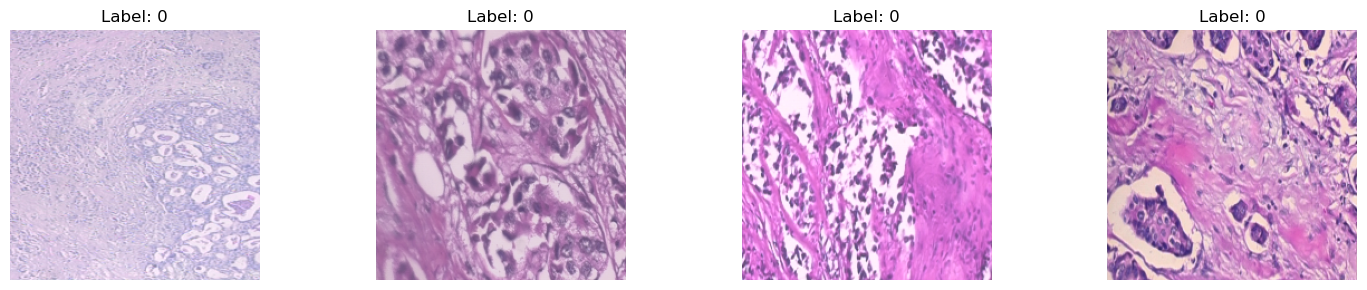

In [14]:
import matplotlib.pyplot as plt

def view_image(dataset, num_images=4):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            axes[i].imshow(images[i].numpy())
            axes[i].set_title(f'Label: {labels[i].numpy()}')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Before running this function, we make sure the dataset is properly loaded
# Checking if train_ds exists and contains valid data
try:
    # Verify dataset exists and has data
    sample = next(iter(train_ds))
    # If successful, view images
    view_image(train_ds, num_images=4)
except Exception as e:
    print(f"Error: {e}")
    print("Please check that:")
    print("1. The dataset path is correct")
    print("2. The dataset has been properly loaded")
    print("3. The images exist at the specified location")

### Building the Deep learning model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
import tensorflow as tf
import tensorflow_hub as hub

# Creating the base model as a Keras Layer
base_model = hub.KerasLayer(
    "https://tfhub.dev/google/efficientnet/b0/feature-vector/1",
    trainable=False, 
    name='efficientnetv2-b0'
)

# Building the model with improved overfitting prevention
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input_layer'),
    
    # Wrapping the base_model in a functional API to make it compatible with Sequential
    tf.keras.layers.Lambda(lambda x: base_model(x), name='base_model_wrapper'),
    
    # Adding dropout right after base model to prevent overfitting
    Dropout(0.2, name='dropout_base'),
    BatchNormalization(name='bn_base'),
    
    # First dense layer with regularization
    Dense(512, activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(0.001),
          bias_regularizer=tf.keras.regularizers.l2(0.001),
          name='dense_1'),
    BatchNormalization(name='bn_1'),
    Dropout(0.5, name='dropout_1'),
    
    # Second dense layer with regularization
    Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.001),
          bias_regularizer=tf.keras.regularizers.l2(0.001),
          name='dense_2'),
    BatchNormalization(name='bn_2'),
    Dropout(0.4, name='dropout_2'),
    
    # Third dense layer
    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.001),
          name='dense_3'),
    BatchNormalization(name='bn_3'),
    Dropout(0.3, name='dropout_3'),
    
    # Output layer
    Dense(1, activation='sigmoid', name='output_layer')
], name='breast_cancer_classifier')

# Using a lower initial learning rate with ReduceLROnPlateau callback
# This will be set in callbacks, using a moderate initial LR here
initial_learning_rate = 0.0001

# Compiling with appropriate metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    ),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),  # Label smoothing for regularization
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


In [29]:
model.summary()

Model: "breast_cancer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base_model_wrapper (Lambda)     │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_base (Dropout)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_base (BatchNormalization)    │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,929 (3.16 MB)

 Trainable params: 824,577 (3.15 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [32]:
# Setting up logging directory
import datetime
logdir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir, exist_ok=True)

In [34]:
# Creating callbacks for better training and overfitting prevention
import os

# TensorBoard callback for visualization
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,  # Wait 7 epochs before stopping
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait 3 epochs
    min_lr=1e-7,  # Minimum learning rate
    verbose=1,
    mode='min'
)

# Model checkpoint to save best model
os.makedirs('models', exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# CSV logger to track training progress
csv_logger = tf.keras.callbacks.CSVLogger(
    'models/training_log.csv',
    append=False
)

# Compile callbacks list
callbacks = [
    tensorboard_callback,
    early_stopping,
    reduce_lr,
    model_checkpoint,
    csv_logger
]

print("Callbacks configured:")
print(f"  - TensorBoard: {logdir}")
print(f"  - Early Stopping: patience=7")
print(f"  - Reduce LR on Plateau: factor=0.5, patience=3")
print(f"  - Model Checkpoint: models/best_model.keras")
print(f"  - CSV Logger: models/training_log.csv")

Callbacks configured:
  - TensorBoard: logs/fit/20251111-025225
  - Early Stopping: patience=7
  - Reduce LR on Plateau: factor=0.5, patience=3
  - Model Checkpoint: models/best_model.keras
  - CSV Logger: models/training_log.csv


In [ ]:
# Train the model
EPOCHS = 15

print("Starting training...")
print(f'Start time: {datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,  # Use validation set, not test set
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print(f"Best model saved to: models/best_model.h5")
print(f'End time: {datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S")}')


Starting training...
Start time: 20251111-025229
Training samples: 43432
Validation samples: 7789
Test samples: 600
Epoch 1/15
 733/1358 ━━━━━━━━━━━━━━━━━━━━ 5:08 493ms/step - accuracy: 0.6377 - auc: 0.6911 - loss: 1.9923 - precision: 0.6371 - recall: 0.6340

In [ ]:
# Plot training history - Loss
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color="teal", label='Training Loss')
plt.plot(history.history['val_loss'], color="orange", label='Validation Loss')
plt.title('Model Loss', fontsize=20)
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [ ]:
# Plot training history - Accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], color="teal", label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color="orange", label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

### Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
for batch in test_ds.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x, verbose=0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"\nTest Results:")
print(f"  Precision: {pre.result().numpy():.4f}")
print(f"  Recall: {re.result().numpy():.4f}")
print(f"  Accuracy: {acc.result().numpy():.4f}")

# Get detailed classification report
print("\nDetailed Evaluation:")
y_true = []
y_pred = []

for batch in test_ds.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x, verbose=0)
    y_true.extend(y.flatten())
    y_pred.extend((yhat > 0.5).astype(int).flatten())

print(classification_report(y_true, y_pred, target_names=['malignant', 'benign']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

In [ ]:
# Metrics are already printed in the previous cell
# Additional visualization can be added here if needed

In [ ]:
!pip install opencv-python
import cv2

In [ ]:
# Testing prediction on a single image

img_path = '../data/raw/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-021.png'
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
img = img / 255.0
img = tf.expand_dims(img, 0)


prediction = model.predict(img)
if prediction > 0.5:
    print("Predicted class is: Benign")
else:
    print("Predicted class is: Malignant")

In [ ]:
print(type(model))


## Summary of Overfitting Prevention Techniques

This notebook implements multiple techniques to prevent overfitting:

1. **Data Augmentation**: 
   - Random flips (left-right, up-down)
   - Random brightness, contrast, saturation, hue adjustments
   - Random rotations
   - Applied only to training data

2. **Regularization**:
   - L2 regularization on dense layers (0.001)
   - Dropout layers (0.2, 0.5, 0.4, 0.3)
   - Batch normalization after each dense layer
   - Label smoothing (0.1) in loss function

3. **Callbacks**:
   - Early stopping (patience=7) to stop training when validation loss stops improving
   - Reduce learning rate on plateau (factor=0.5, patience=3)
   - Model checkpointing to save best model based on validation loss
   - TensorBoard for monitoring training

4. **Data Handling**:
   - Proper train/validation/test split
   - Class balancing through oversampling in training set
   - Separate validation set (not using test set for validation)

5. **Model Architecture**:
   - Transfer learning with frozen EfficientNetV2-B0 base
   - Progressive dropout (higher in early layers)
   - Multiple dense layers with regularization
   - Lower initial learning rate (0.0001)


# Saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Save the final model (best model is already saved by ModelCheckpoint callback)
# Option 1: Save the current model state
model.save(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

# Option 2: Load and save the best model from checkpoint
# The best model based on validation loss is already saved as 'models/best_model.h5'
# print("Model saved successfully!")
# print("Best model (based on validation loss): models/best_model.h5")
# print("Final model: models/Breast_Cancer_Histopathology_Image_Classification_model.keras")

In [ ]:
# Load the best model (saved by ModelCheckpoint callback)
best_model = load_model('models/best_model.h5')
print("Best model loaded successfully!")

# Or load the final model
# final_model = load_model(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

In [ ]:
# Example: Predict on a single image
# Replace 'path/to/image.png' with your actual image path
# img_path = 'path/to/image.png'
# img = tf.io.read_file(img_path)
# img = tf.image.decode_image(img, channels=3)
# img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
# img = img / 255.0
# img = tf.expand_dims(img, 0)
# 
# prediction = best_model.predict(img, verbose=0)
# print(f"Prediction probability: {prediction[0][0]:.4f}")
# if prediction[0][0] > 0.5:
#     print("Predicted class is: Benign")
# else:
#     print("Predicted class is: Malignant")